# 模型训练

https://www.tensorflow.org/guide/keras/train_and_evaluate

- [1. 一般流程](#1.一般流程)

- [2. 损失Loss](#2.损失Loss)

  - [2.1 自定义损失](#2.1自定义损失)
  

- [3. 指标Metric](#3.指标Metric)

- [4. 优化器Optimizer](#4.优化器Optimizer)

- [5. tf.data](#5.tf.data)

- [6. 样本权重和类权重](#6.样本权重和类权重)

- [7. 多输入多输出模型](#7.多输入多输出模型)

- [8. 使用回调](#8.使用回调)

- [9. 自行构造训练流程](#9.自行构造训练流程)


In [12]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.keras.backend.clear_session()
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## 1.一般流程

- 采用keras比较常规的compile和fit训练方式
- 采用custom training loops，自由度较高

In [2]:
# 模型构造
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

# 载入数据
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255

x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

# 训练模型
history = model.fit(x_train, y_train, batch_size=64, epochs=3, validation_data=(x_val, y_val))
print('history:')
print(history.history)

result = model.evaluate(x_test, y_test, batch_size=128)
print('evaluate:')
print(result)
pred = model.predict(x_test[:2])
print('predict:')
print(pred)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 43us/sample - loss: 0.3406 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.1693 - val_sparse_categorical_accuracy: 0.9534
Epoch 2/3
50000/50000 [==============================] - 2s 33us/sample - loss: 0.1557 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.1263 - val_sparse_categorical_accuracy: 0.9629
Epoch 3/3
50000/50000 [==============================] - 2s 33us/sample - loss: 0.1129 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.1134 - val_sparse_categorical_accuracy: 0.9659
history:
{'loss': [0.34061549639582633, 0.15569830632925033, 0.11287801637411117], 'sparse_categorical_accuracy': [0.9027, 0.95436, 0.96544], 'val_loss': [0.16925939092636108, 0.1263127308666706, 0.11337280856966972], 'val_sparse_categorical_accuracy': [0.9534, 0.9629, 0.9659]}
10000/10000 [==============================] - 0s 10us/sample - loss: 0.1040 - sparse_categorical_accuracy: 0.969

In [ ]:
"""
不是第一次看到了，在A01quickstart的第二章节看过类似的例子
"""

import numpy as np
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Adding a dimension to the array -> new shape == (28, 28, 1)
train_images = train_images[..., None]     # (60000, 28, 28) =>  (60000, 28, 28, 1)
test_images = test_images[..., None]       # (10000, 28, 28) =>  (10000, 28, 28, 1)

# Getting the images in [0, 1] range.
train_images = train_images / np.float32(255)
test_images = test_images / np.float32(255)

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

# dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)).shuffle(10000).batch(32)   # type(train_ds)=>tensorflow.python.data.ops.dataset_ops.BatchDataset                                                                                                                                                                        
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)).batch(32)

# Model
class MyModel(tf.keras.Sequential):
    def __init__(self):
        super(MyModel, self).__init__([
          tf.keras.layers.Conv2D(32, 3, activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(64, 3, activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(10, activation=None)
        ])

model = MyModel()

# optimizer
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

# checkpoint
checkpoint = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, './tf_ckpts', max_to_keep=3)

# loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# metric
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# define a train step
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(targets, predictions)
        loss += sum(model.losses)  # add other losses
    # compute gradients and update variables
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_metric(loss)
    train_acc_metric(targets, predictions)

# define a test step
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_object(targets, predictions)
    test_loss_metric(loss)
    test_acc_metric(targets, predictions)

# train loop
epochs = 10
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset
    for step, (inputs, targets) in enumerate(train_ds):
        train_step(inputs, targets)
        checkpoint.step.assign_add(1)
        # log every 20 step
        if step % 20 == 0:
            manager.save() # save checkpoint
            print('Epoch: {}, Step: {}, Train Loss: {}, Train Accuracy: {}'.format(
                epoch, step, train_loss_metric.result().numpy(),
                train_acc_metric.result().numpy())
            )
            train_loss_metric.reset_states()
            train_acc_metric.reset_states()

# do test
for inputs, targets in test_ds:
    test_step(inputs, targets)
print('Test Loss: {}, Test Accuracy: {}'.format(
    test_loss_metric.result().numpy(),
    test_acc_metric.result().numpy()))

## 2.损失Loss

对于losses，其本身就是对各种loss函数的封装，位于 `tf.keras.losses`

https://www.tensorflow.org/api_docs/python/tf/keras/losses

A | B | C | D | others
---|--- |--- |--- |---
BinaryCrossentropy | MeanAbsoluteError | CategoricalHinge | CosineSimilarity | KLDivergence
CategoricalCrossentropy | MeanAbsolutePercentageError | Hinge | LogCosh | Poisson
SparseCategoricalCrossentropy | MeanSquaredError | SquaredHinge | - | Reduction
- | MeanSquaredLogarithmicError | Huber | - | -


[回到目录](#模型训练)

In [3]:
bce = tf.keras.losses.BinaryCrossentropy()
loss = bce([0., 0., 1., 1.], [1., 1., 1., 0.])
print('Loss: ', loss.numpy())  # Loss: 11.522857

Loss:  11.522857


### 2.1自定义损失

In [4]:
"""
自定义损失loss
以定义网络层的方式添加网络loss
"""

class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = ActivityRegularizationLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)

model = keras.Model(inputs, outputs)
model.summary()
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_input (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
activity_regularization_laye (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
50000/50000 [==============================] - 3s 59us/sample - loss: 2.3478 - sparse_categorical_accuracy: 0.1136


## 3.指标Metric

https://www.tensorflow.org/api_docs/python/tf/keras/metrics

A | B | C | D | E | others
---|---|---|---|---|---
Precision | BinaryAccuracy | Sum | CategoricalHinge |CosineSimilarity |KLDivergence
Recall | BinaryCrossentropy | Mean |Hinge | LogCoshError | Poisson
Accuracy |  CategoricalAccuracy |  MeanAbsoluteError |SquaredHinge | - |SensitivityAtSpecificity
TruePositives | CategoricalCrossentropy  | MeanAbsolutePercentageError | - | - | SpecificityAtSensitivity
TrueNegatives | TopKCategoricalAccuracy  | MeanIoU | - | - | -
FalsePositives  | SparseCategoricalAccuracy | MeanRelativeError |- | - | -
FalseNegatives |  SparseCategoricalCrossentropy | MeanSquaredError |- | - | -
AUC  | SparseTopKCategoricalAccuracy |   MeanSquaredLogarithmicError |- | - | -
-  | - |   RootMeanSquaredError | - | - | -


In [9]:
"""
metrics模块主要包含了常用的模型评估指标，
这个模块与TensorFlow 1.x的metrics模块设计理念是一致的，就是metric本身是有状态的，一般是通过创建Variable来记录。
"""

m = tf.keras.metrics.Accuracy()
m.update_state([1, 2, 3, 4], [0, 2, 3, 4])
print('result: ', m.result().numpy())  # result: 0.75
m.update_state([0, 2, 3], [1, 2, 3])
print('result: ', m.result().numpy())  #  result: 0.714
m.reset_states()  # 重置
m.update_state([0, 2, 3], [1, 2, 3])
print('result: ', m.result().numpy())  #  result: 0.667

result:  0.75
result:  0.71428573
result:  0.6666667


### 3.1自定义指标



- 继承Metric类，重写函数

三个接口必须都要实现，update_state是通过添加新数据而更新状态，而reset_states是重置初始值，result方法是获得当前状态，即metric结果

>\__init\__(self)，初始化。

>update_state(self，y_true，y_pred，sample_weight = None)，它使用目标y_true和模型预测y_pred来更新状态变量。

>result(self)，它使用状态变量来计算最终结果。

>reset_states(self)，重新初始化度量的状态。

- 定义网络层的方式添加要统计的metric
- 直接在model上面加



[回到目录](#模型训练)

In [5]:
# 这是一个简单的示例，显示如何实现CatgoricalTruePositives指标，该指标计算正确分类为属于给定类的样本数量

class CatgoricalTruePostives(keras.metrics.Metric):
    def __init__(self, name='binary_true_postives', **kwargs):
        super(CatgoricalTruePostives, self).__init__(name=name, **kwargs)
        self.true_postives = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred)
        y_true = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
        
        y_true = tf.cast(y_true, tf.float32)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            y_true = tf.multiply(sample_weight, y_true)
            
        return self.true_postives.assign_add(tf.reduce_sum(y_true))
    
    def result(self):
        return tf.identity(self.true_postives)
    
    def reset_states(self):
        self.true_postives.assign(0.)
        

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[CatgoricalTruePostives()])

model.fit(x_train, y_train, batch_size=64, epochs=3) 

Epoch 1/3
50000/50000 [==============================] - 2s 36us/sample - loss: 2.3014 - binary_true_postives: 49252.0000
Epoch 2/3
50000/50000 [==============================] - 2s 30us/sample - loss: 2.3013 - binary_true_postives: 49288.0000
Epoch 3/3
50000/50000 [==============================] - 1s 30us/sample - loss: 2.3012 - binary_true_postives: 49320.0000


In [6]:
# 也可以以定义网络层的方式添加要统计的metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
        
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = MetricLoggingLayer()(h1)                         # ★★★★★
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 3s 59us/sample - loss: 0.3075 - sparse_categorical_accuracy: 0.9121 - std_of_activation: 0.9840


In [7]:
# 也可以直接在model上面加，此处发现loss也可以直接在model上加
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h2 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = keras.Model(inputs, outputs)

model.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')                # ★★★★★ 
model.add_loss(tf.reduce_sum(h1)*0.1)

# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 4s 72us/sample - loss: 2.3470 - sparse_categorical_accuracy: 0.1129 - std_of_activation: 0.3083


### 注意：model.fit中参数的使用

https://www.tensorflow.org/api_docs/python/tf/keras/Model?version=stable#fit

**validation_split 只能在用numpy数据训练的情况下使用**

可以用`validation_data`参数指定验证数据集

In [8]:
model.fit(x_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 86us/sample - loss: 2.3013 - sparse_categorical_accuracy: 0.1141 - std_of_activation: 0.3087 - val_loss: 2.3014 - val_sparse_categorical_accuracy: 0.1115 - val_std_of_activation: 0.3065


## 4.优化器Optimizer

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

class `Adadelta`: Optimizer that implements the Adadelta algorithm.

class `Adagrad`: Optimizer that implements the Adagrad algorithm.

class `Adam`: Optimizer that implements the Adam algorithm.

class `Adamax`: Optimizer that implements the Adamax algorithm.

class `Ftrl`: Optimizer that implements the FTRL algorithm.

class `Nadam`: Optimizer that implements the NAdam algorithm.

**class Optimizer: Updated base class for optimizers.**

class `RMSprop`: Optimizer that implements the RMSprop algorithm.

class `SGD`: Stochastic gradient descent and momentum optimizer.

**策略部分**

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules

```python
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)
```
内置的有：`ExponentialDecay`  `PiecewiseConstantDecay` `PolynomialDecay`  `InverseTimeDecay`


[回到目录](#模型训练)

## 5.tf.data

在开始模型训练之前，一个重要的项是数据加载，TensorFlow 2.0的数据加载还是采用tf.data，不过在eager模式下，tf.data.Dataset这个类将成为一个Python迭代器，我们可以直接取值：
```python
dataset = tf.data.Dataset.range(10)
for i, elem in enumerate(dataset):
    print(elem)  # prints 0, 1, ..., 9
```
这里我们只是展示了一个简单的例子，但是足以说明tf.data在TensorFlow 2.0下的变化，tf.data其它使用技巧和TensorFlow 1.x是一致的。

详情请见 [A07载入数据](A07load-data.ipynb)

[回到目录](#模型训练)

In [10]:
def get_compiled_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

model = get_compiled_model()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# model.fit(train_dataset, epochs=3)
# steps_per_epoch 每个epoch只训练几步
# validation_steps 每次验证，验证几步
model.fit(train_dataset, epochs=3, steps_per_epoch=100,
         validation_data=val_dataset, validation_steps=3)

Epoch 1/3
100/100 [==============================] - 1s 13ms/step - loss: 0.8327 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.4068 - val_sparse_categorical_accuracy: 0.8854
Epoch 2/3
100/100 [==============================] - 0s 4ms/step - loss: 0.3662 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.3002 - val_sparse_categorical_accuracy: 0.9219
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.3024 - sparse_categorical_accuracy: 0.9097 - val_loss: 0.2241 - val_sparse_categorical_accuracy: 0.9271


## 6.样本权重和类权重

“样本权重”数组是一个数字数组，用于指定批处理中每个样本在计算总损失时应具有多少权重。 它通常**用于不平衡的分类问题**（这个想法是为了给予很少见的类更多的权重）。 当使用的权重是1和0时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类权重”dict是同一概念的更具体的实例：它将类索引映射到应该用于属于该类的样本的样本权重。 例如，**如果类“0”比数据中的类“1”少两倍，则可以使用class_weight = {0：1.，1：0.5}。**

[回到目录](#模型训练)

In [13]:
# 增加第5类的权重
import numpy as np
# 类权重
model = get_compiled_model()
class_weight = {i:1.0 for i in range(10)}
class_weight[5] = 2.0
print(class_weight)
model.fit(x_train, y_train,
         class_weight=class_weight,
         batch_size=64,
         epochs=4)

# 样本权重
model = get_compiled_model()
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0
model.fit(x_train, y_train,
         sample_weight=sample_weight,
         batch_size=64,
         epochs=4)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
Epoch 1/4
50000/50000 [==============================] - 2s 39us/sample - loss: 0.3764 - sparse_categorical_accuracy: 0.9014
Epoch 2/4
50000/50000 [==============================] - 2s 33us/sample - loss: 0.1717 - sparse_categorical_accuracy: 0.9527
Epoch 3/4
50000/50000 [==============================] - 2s 37us/sample - loss: 0.1261 - sparse_categorical_accuracy: 0.9642
Epoch 4/4
50000/50000 [==============================] - 2s 34us/sample - loss: 0.1022 - sparse_categorical_accuracy: 0.9714
Epoch 1/4
50000/50000 [==============================] - 2s 38us/sample - loss: 0.3806 - sparse_categorical_accuracy: 0.8980
Epoch 2/4
50000/50000 [==============================] - 2s 34us/sample - loss: 0.1778 - sparse_categorical_accuracy: 0.9518
Epoch 3/4
50000/50000 [==============================] - 2s 34us/sample - loss: 0.1322 - sparse_categorical_accuracy: 0.9628
Epoch 4/4
50000/50000 [=====================

In [ ]:
# tf.data 和 样本权重
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))   # ★★
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, )

## 7.多输入多输出模型

[回到目录](#模型训练)

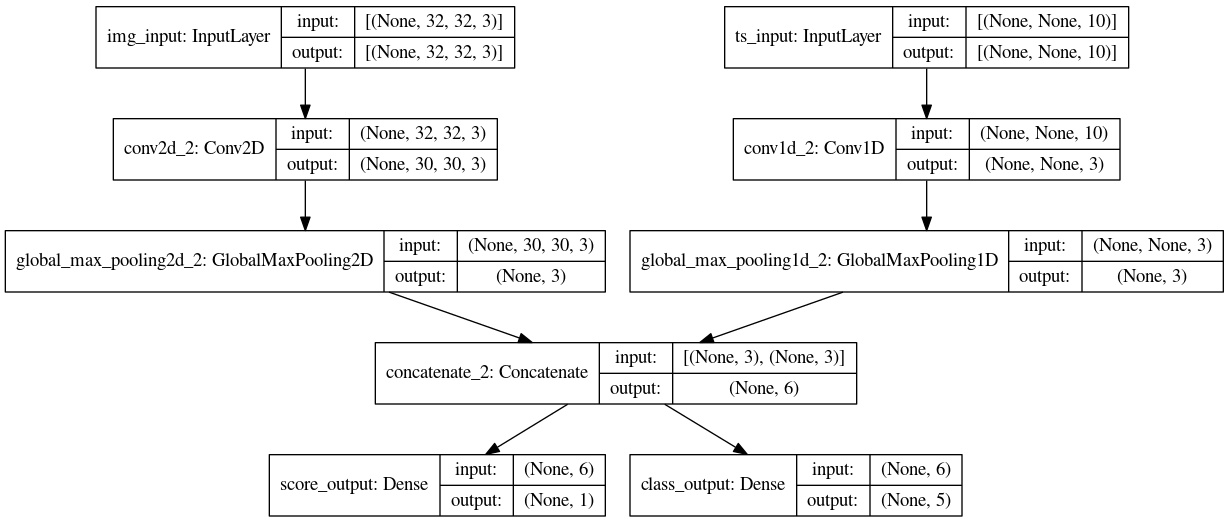

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

**怎么训练？**

```python
# 可以为模型指定不同的loss和metrics
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# 还可以指定loss的权重
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weight={'score_output': 2., 'class_output': 1.})

# 可以把不需要传播的loss置0
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()])

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output': keras.losses.CategoricalCrossentropy()})
```
WARNING:tensorflow:Output score_output missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to score_output.

In [21]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# Generate dummy Numpy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets],
          batch_size=32,
          epochs=3)

# Alternatively, fit on dicts
model.fit({'img_input': img_data, 'ts_input': ts_data},
          {'score_output': score_targets, 'class_output': class_targets},
          batch_size=32,
          epochs=3)

Epoch 1/3
100/100 [==============================] - 0s 3ms/sample - loss: 5.8647 - score_output_loss: 0.6958 - class_output_loss: 5.1689
Epoch 2/3
100/100 [==============================] - 0s 279us/sample - loss: 5.3265 - score_output_loss: 0.3055 - class_output_loss: 5.0210
Epoch 3/3
100/100 [==============================] - 0s 264us/sample - loss: 5.1200 - score_output_loss: 0.1810 - class_output_loss: 4.9391
Epoch 1/3
100/100 [==============================] - 0s 2ms/sample - loss: 5.0012 - score_output_loss: 0.1489 - class_output_loss: 4.8523
Epoch 2/3
100/100 [==============================] - 0s 2ms/sample - loss: 4.8900 - score_output_loss: 0.1331 - class_output_loss: 4.7569
Epoch 3/3
100/100 [==============================] - 0s 2ms/sample - loss: 4.8127 - score_output_loss: 0.1301 - class_output_loss: 4.6826


## 8.使用回调

Keras中的回调是在训练期间（在epoch开始时，batch结束时，epoch结束时等）在不同点调用的对象，可用于实现以下行为：

- 在培训期间的不同时间点进行验证（超出内置的每个时期验证）
- 定期检查模型或超过某个精度阈值
- 在训练似乎平稳时改变模型的学习率
- 在训练似乎平稳时对顶层进行微调
- 在培训结束或超出某个性能阈值时发送电子邮件或即时消息通知等等。

**可使用的内置回调有**

- ModelCheckpoint：定期保存模型。
- EarlyStopping：当训练不再改进验证指标时停止培训。
- TensorBoard：定期编写可在TensorBoard中显示的模型日志（更多细节见[可视化](https://www.tensorflow.org/tensorboard)）。
- CSVLogger：将丢失和指标数据流式传输到CSV文件。
- ...

[回到目录](#模型训练)

In [22]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 2s 50us/sample - loss: 0.3727 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.2486 - val_sparse_categorical_accuracy: 0.9269
Epoch 2/20
40000/40000 [==============================] - 1s 37us/sample - loss: 0.1782 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.1867 - val_sparse_categorical_accuracy: 0.9422
Epoch 3/20
40000/40000 [==============================] - 1s 37us/sample - loss: 0.1303 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.1529 - val_sparse_categorical_accuracy: 0.9541
Epoch 4/20
40000/40000 [==============================] - 1s 37us/sample - loss: 0.1020 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.1425 - val_sparse_categorical_accuracy: 0.9597
Epoch 5/20
40000/40000 [==============================] - 1s 37us/sample - loss: 0.0850 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.1505 - val_sparse_categorical_accuracy: 0.9599
Epoch 6/20
4000

In [23]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
39936/40000 [============================>.] - ETA: 0s - loss: 0.3784 - sparse_categorical_accuracy: 0.8916
Epoch 00001: val_loss improved from inf to 0.27112, saving model to mymodel_1.h5
40000/40000 [==============================] - 2s 46us/sample - loss: 0.3786 - sparse_categorical_accuracy: 0.8916 - val_loss: 0.2711 - val_sparse_categorical_accuracy: 0.9153
Epoch 2/3
38528/40000 [===========================>..] - ETA: 0s - loss: 0.1784 - sparse_categorical_accuracy: 0.9464
Epoch 00002: val_loss improved from 0.27112 to 0.18934, saving model to mymodel_2.h5
40000/40000 [==============================] - 1s 36us/sample - loss: 0.1771 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.1893 - val_sparse_categorical_accuracy: 0.9419
Epoch 3/3
39168/40000 [============================>.] - ETA: 0s - loss: 0.1290 - sparse_categorical_accuracy: 0.9605
Epoch 00003: val_loss improved from 0.18934 to 0.16096, saving model to mymode

In [24]:
# tensorboard --logdir=/full_path_to_your_logs 可视化查看日志内容

tensorboard_cbk = keras.callbacks.TensorBoard(
  log_dir='/full_path_to_your_logs',
  histogram_freq=0,  # How often to log histogram visualizations
  embeddings_freq=0,  # How often to log embedding visualizations
  update_freq='epoch')  # How often to write logs (default: once per epoch)

model.fit(x_train, y_train,
         epochs=5,
         batch_size=64,
         callbacks=[tensorboard_cbk],
         validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 2s 42us/sample - loss: 0.1012 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.1469 - val_sparse_categorical_accuracy: 0.9576
Epoch 2/5
40000/40000 [==============================] - 2s 38us/sample - loss: 0.0822 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.1474 - val_sparse_categorical_accuracy: 0.9578
Epoch 3/5
40000/40000 [==============================] - 2s 39us/sample - loss: 0.0684 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.1344 - val_sparse_categorical_accuracy: 0.9613
Epoch 4/5
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0589 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.1344 - val_sparse_categorical_accuracy: 0.9657
Epoch 5/5
40000/40000 [==============================] - 2s 38us/sample - loss: 0.0513 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.1388 - val_sparse_categorical_accuracy: 0.9660


### 其他用法
- Using callbacks to implement a dynamic learning rate schedule

A dynamic learning rate schedule (for instance, decreasing the learning rate when the validation loss is no longer improving) cannot be achieved with these schedule objects since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can thus achieve this pattern by using a callback that modifies the current learning rate on the optimizer. In fact, this is even built-in as the `ReduceLROnPlateau` callback.

- 多个callbacks

```python
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
model.fit(train_x, train_y, batch_size=16, epochs=5,
         callbacks=callbacks, validation_data=(val_x, val_y))
```

- 创建自己的回调方法

https://www.tensorflow.org/guide/keras/custom_callback

```python
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses = []
    def on_epoch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
        print('\nloss:',self.losses[-1])
        
model = get_compiled_model()

callbacks = [
    LossHistory()
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)
```

[回到目录](#模型训练)

## 9.自行构造训练流程

- [9.1 使用GradientTape](#9.1使用GradientTape)
- [9.2 使用Metrics](#9.2使用Metrics)
- [9.3 使用自定义的loss](#9.3使用自定义的loss)

[回到目录](#模型训练)

### 9.1使用GradientTape

In [25]:
# Get the model.
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# 自己构造循环
for epoch in range(3):
    print('epoch: ', epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # 开一个gradient tape, 计算梯度
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            
            loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

epoch:  0
Training loss (for one batch) at step 0: 2.463557004928589
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2825393676757812
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.178082227706909
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.124694347381592
Seen so far: 38464 samples
epoch:  1
Training loss (for one batch) at step 0: 2.140631675720215
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9843699932098389
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.8294868469238281
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.8115460872650146
Seen so far: 38464 samples
epoch:  2
Training loss (for one batch) at step 0: 1.8379809856414795
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.6191942691802979
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.4015848636627197
Seen so far: 25664 samples
Training l

### 9.2使用Metrics

In [26]:
# Get model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy() 
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
    # Update training metric.
    train_acc_metric(y_batch_train, logits)

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

  # Display metrics at the end of each epoch.
  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))
  # Reset training metrics at the end of each epoch
  train_acc_metric.reset_states()

  # Run a validation loop at the end of each epoch.
  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: 2.3806729316711426
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2563037872314453
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.119673490524292
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.0766963958740234
Seen so far: 38464 samples
Training acc over epoch: 0.25332000851631165
Validation acc: 0.42590001225471497
Start of epoch 1
Training loss (for one batch) at step 0: 2.0414552688598633
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9612574577331543
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.8063271045684814
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7116385698318481
Seen so far: 38464 samples
Training acc over epoch: 0.49838000535964966
Validation acc: 0.5934000015258789
Start of epoch 2
Training loss (for one batch) at step 0: 1.676201343536377
Seen so far: 64 samples
Trai

### 9.3使用自定义的loss

In [30]:
##　添加自己构造的loss, 每次只能看到最新一次训练增加的loss
class ActivityRegularizationLayer(layers.Layer):
  def call(self, inputs):
    self.add_loss(1e-2 * tf.reduce_sum(inputs))
    return inputs
  
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = ActivityRegularizationLayer()(x)      # Insert activity regularization as a layer
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
logits = model(x_train[:64])
print(model.losses)
logits = model(x_train[:64])
logits = model(x_train[64: 128])
logits = model(x_train[128: 192])
print(model.losses)        # display the latest losses

[<tf.Tensor: id=1011278, shape=(), dtype=float32, numpy=6.6054897>]
[<tf.Tensor: id=1011339, shape=(), dtype=float32, numpy=6.715292>]


In [31]:
# 将loss添加进求导中
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)

      # Add extra losses created during this forward pass:
      loss_value += sum(model.losses)
      
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 9.299819946289062
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.5523834228515625
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.414079189300537
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3344929218292236
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.3324875831604004
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3382205963134766
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3406896591186523
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3131072521209717
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.3144371509552
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3209519386291504
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.324777126312256
Seen so far: 25664